# NLP Topic Modelling on PureGym Reviews

**Author:** Matt Cocker  
**Date:** [July 2025]  
**Project Type:** NLP | Topic Modelling | Customer Insight

---

## About this Notebook

This notebook applies topic modelling and emotion analysis to customer reviews from PureGym to uncover key drivers of member behaviour and sentiment. It supports business insight generation by identifying dominant themes and emotional tones in user feedback.

The notebook uses BERTopic for topic modelling, with LDA for comparison in a separate notebook, BERT for emotion analysis and LLMs for summarisation and insight generation.

**Key Tasks:**
- Load cleaned review data
- Apply topic modelling
- Analyse emotion and sentiment
- Visualise topic distributions

*Note: The original dataset used in this notebook is under NDA and not accessible.  Any data loading or Drive mounting steps have been replaced with placeholders, and outputs that show the raw data have been cleared.*

# Installations

In [ ]:
# Install langid
!pip install -q langid bertopic transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Imports

The below bits of code are to mount my Drive to allow me to save things using pickle and silence any loading bars from HuggingFace transformers.

In [ ]:
# --- Standard libraries
import os
import pickle
import gdown

# --- Analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import langid
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import re
import string
from wordcloud import WordCloud
from bertopic import BERTopic
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
from umap import UMAP
from hdbscan import HDBSCAN

# --- Data
# from google.colab import drive
# drive.mount('/content/drive')
# Drive access removed for this public version – data loading uses placeholder below

# --- NLTK setup

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)


# Loading Data

We will start by importing the datasets from the Google Drive folder - the links have been renamed for confidentiality purposes.

In [ ]:
# The shared Google Drive folder link
folder_url = 'data_file'

# Get the folder ID from the URL
folder_id = folder_url.split('/')[-1]

# Create a directory to save the files
output_dir = '/content/puregym_data'
os.makedirs(output_dir, exist_ok=True)

# Download the files in the folder
gdown.download_folder(id=folder_id, output=output_dir, quiet=True)

print(f"Files downloaded to {output_dir}")

# Load the files into dataframes
google_df = pd.read_excel(os.path.join(output_dir, 'Google'))
trustpilot_df = pd.read_excel(os.path.join(output_dir, 'Trustpilot'))

print("\nGoogle Reviews DataFrame:")
display(google_df.head())

print("\nTrustpilot Reviews DataFrame:")
display(trustpilot_df.head())

# Data Cleaning





First step is to remove any samples without text in the review.

In [ ]:
# Remove rows with missing values in the 'Comment' column of google_df
google = google_df.dropna(subset=['Comment'])

# Remove rows with missing values in the 'Review Content' column of trustpilot_df
trustpilot = trustpilot_df.dropna(subset=['Review Content'])

print("Google Reviews DataFrame after removing missing comments:")
display(google.head())

print("\nTrustpilot Reviews DataFrame after removing missing review content:")
display(trustpilot.head())

Next we'll find the number of unique locations in each set of reviews, and the number of common locations across both sets for a better picture of the data.

In [ ]:
# Find the number of unique locations in the Google data set.

nunique_locs_google = google['Club\'s Name'].nunique()
print(f"Number of unique locations in the Google data set: {nunique_locs_google}")

# Find the number of unique locations in the Trustpilot data set.

nunique_locs_trustpilot = trustpilot['Location Name'].nunique()
print(f"Number of unique locations in the Trustpilot data set: {nunique_locs_trustpilot}")

# Find the number of common locations between the Google data set and the Trustpilot data set.

common_locs = set(google['Club\'s Name']).intersection(trustpilot['Location Name'])
ncommon_locs = len(common_locs)
print(f"Number of common locations between the Google data set and the Trustpilot data set: {ncommon_locs}")

Number of unique locations in the Google data set: 512
Number of unique locations in the Trustpilot data set: 376
Number of common locations between the Google data set and the Trustpilot data set: 310


# Data Preprocessing

There are some reviews that aren't written in English. To prevent these from causing issues in the analysis, they will be removed using langid.

In [ ]:
# Define a function to filter English-language rows
def filter_english_reviews(df, text_column):
    return df[df[text_column].apply(lambda x: isinstance(x, str) and langid.classify(x)[0] == 'en')].reset_index(drop=True)

# Apply the function to both the Google and Trustpilot DataFrames
google = filter_english_reviews(google, 'Comment')
trustpilot = filter_english_reviews(trustpilot, 'Review Content')

Next step is to perform preprocessing of the data. We will start by changing words to lower case then remove stopwords and numbers, and finally tokenise the reviews using word_tokenize from NLTK.

*I have added the words 'Gym', 'Pure' and 'PureGym' to the stopwords dictionary as these words are likely to come up very frequently due to being the name of the gym but offer little to no meaning. Also adding 'im' - it shows up and I'm assuming it's to do with what the order of operations does to I'm. I have also removed the word 'no' from the stopwords dictionary as it is important to the meaning of reviews - the list and loop is set up in case I want to easily modify it.*

In [ ]:
# Define a function to remove numbers

def remove_numbers(text):
    # Use regular expressions to remove numbers
    return re.sub(r'\d+', '', text)

# Get English stopwords
stop_words = set(stopwords.words(['english']))

# Add the words 'Gym', 'Pure' and 'PureGym' to the stopwords dictionary to prevent them from skewing the dataset
stop_words.update(['gym', 'pure', 'puregym','im'])

# Set up a list of words that may erroneously be removed and set up a loop to discard them from the stopwords dictionary to ensure they're kept
words_to_keep = ['no']
for word in words_to_keep:
    stop_words.discard(word)

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove numbers using the previously defined function
    text = remove_numbers(text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

# Apply preprocessing to the 'Comment' column in the google dataframe
google['cleaned_comment'] = google['Comment'].apply(preprocess_text)

# Apply preprocessing to the 'Review Content' column in the trustpilot dataframe
trustpilot['cleaned_review_content'] = trustpilot['Review Content'].apply(preprocess_text)

print("Google Reviews DataFrame with cleaned and tokenized comments:")
display(google[['Comment', 'cleaned_comment']].head())

print("\nTrustpilot Reviews DataFrame with cleaned and tokenized review content:")
display(trustpilot[['Review Content', 'cleaned_review_content']].head())

# Initial Analysis of All Reviews

We'll start our initial analysis with a basic look at the most common words in the full set of reviews using FreqDist from NLTK.

In [ ]:
# Find the frequency distribution of words for Google reviews
all_words_google = [word for tokens in google['cleaned_comment'] for word in tokens]
freq_dist_google = FreqDist(all_words_google)

print("Frequency Distribution for Google Reviews (Top 10):")
print(freq_dist_google.most_common(10))

# Find the frequency distribution of words for Trustpilot reviews
all_words_trustpilot = [word for tokens in trustpilot['cleaned_review_content'] for word in tokens]
freq_dist_trustpilot = FreqDist(all_words_trustpilot)

print("\nFrequency Distribution for Trustpilot Reviews (Top 10):")
print(freq_dist_trustpilot.most_common(10))

Frequency Distribution for Google Reviews (Top 10):
[('equipment', 3576), ('great', 3456), ('good', 3377), ('staff', 2695), ('classes', 2286), ('clean', 1800), ('no', 1741), ('friendly', 1725), ('machines', 1694), ('always', 1683)]

Frequency Distribution for Trustpilot Reviews (Top 10):
[('equipment', 4357), ('good', 3999), ('great', 3687), ('staff', 3534), ('no', 2508), ('friendly', 2481), ('clean', 2443), ('classes', 2239), ('easy', 2165), ('really', 1749)]


We'll plot the results, starting with showing the top 10 words in each of the Google and Trustpilot datasets on bar chart.

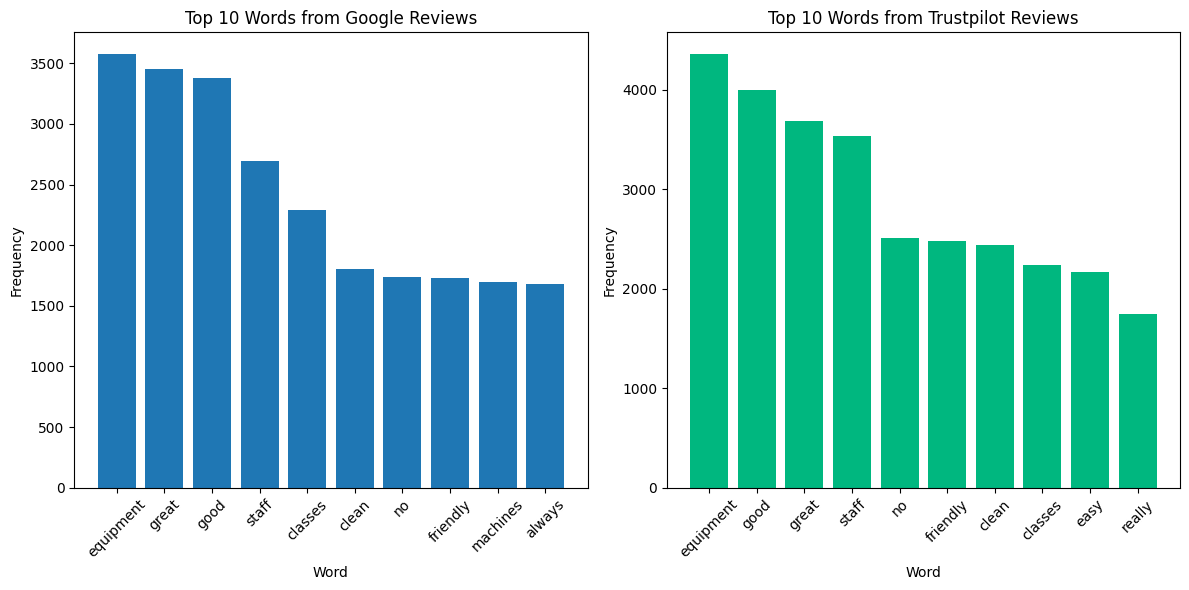

In [ ]:
# Plot a bar plot showing the top 10 words from each data set.

plt.figure(figsize=(12, 6))

# Get top 10 words and their frequencies for Google reviews
top_words_google = freq_dist_google.most_common(10)
words_google = [word for word, freq in top_words_google]
freqs_google = [freq for word, freq in top_words_google]

# Plot the top 10 words from Google reviews in a bar plot
plt.subplot(1, 2, 1)
plt.bar(words_google, freqs_google)
plt.title('Top 10 Words from Google Reviews')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)


# Get top 10 words and their frequencies for Trustpilot reviews
top_words_trustpilot = freq_dist_trustpilot.most_common(10)
words_trustpilot = [word for word, freq in top_words_trustpilot]
freqs_trustpilot = [freq for word, freq in top_words_trustpilot]

# Plot the top 10 words from Trustpilot reviews in a bar plot
plt.subplot(1, 2, 2)
plt.bar(words_trustpilot, freqs_trustpilot, color='#00B77F') # Hex code for Trustpilot green
plt.title('Top 10 Words from Trustpilot Reviews')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

Next we'll create a Word Cloud for each set of reviews.

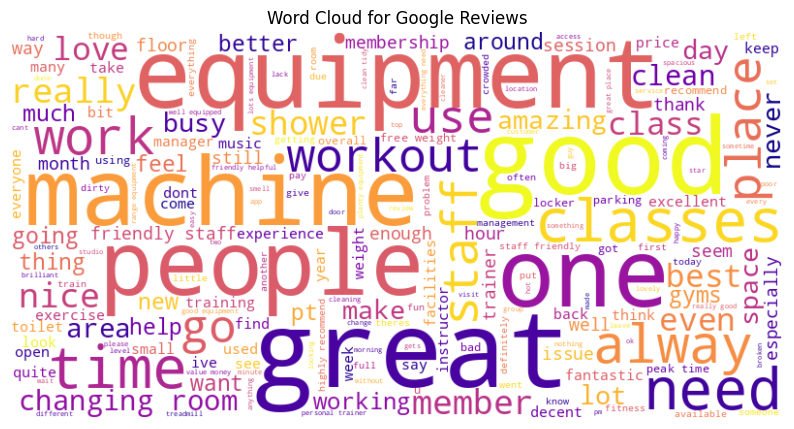

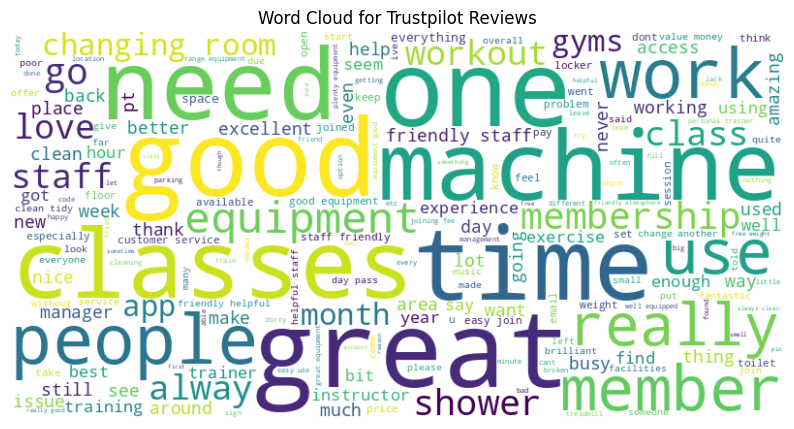

In [ ]:
# Generate word cloud for Google reviews
all_words_google_text = " ".join(all_words_google)
wordcloud_google = WordCloud(width=800, height=400, random_state=19, max_font_size=110, background_color="white", colormap='plasma').generate(all_words_google_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_google, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Google Reviews')
plt.show()

# Generate word cloud for Trustpilot reviews with a different colourmap
all_words_trustpilot_text = " ".join(all_words_trustpilot)
wordcloud_trustpilot = WordCloud(width=800, height=400, random_state=19, max_font_size=110, background_color="white", colormap='viridis').generate(all_words_trustpilot_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_trustpilot, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Trustpilot Reviews')
plt.show()

# Analysis of Negative Reviews

To identify areas for PureGym to improve, we'll look at the common issues people have by looking at negative reviews. We'll extract the negative reviews from both data sets by taking the ones with scores / stars < 3.

In [ ]:
# Filter Google reviews for negative scores (< 3)
neg_google_reviews = google[google['Overall Score'] < 3].copy()

# Filter Trustpilot reviews for negative stars (< 3)
neg_trustpilot_reviews = trustpilot[trustpilot['Review Stars'] < 3].copy()

print("Negative Google Reviews DataFrame:")
display(neg_google_reviews.head())

print("\nNegative Trustpilot Reviews DataFrame:")
display(neg_trustpilot_reviews.head())

We'll do the same as above - find the frequency distribution of words from each dataset's negative reviews and plot the 10 most common on a bar plot.

In [ ]:
# Find the frequency distribution of words for Google reviews
neg_words_google = [word for tokens in neg_google_reviews['cleaned_comment'] for word in tokens]
fd_neg_google = FreqDist(neg_words_google)

print("Frequency Distribution for Google Reviews (Top 10):")
print(fd_neg_google.most_common(10))

# Find the frequency distribution of words for Trustpilot reviews
neg_words_trustpilot = [word for tokens in neg_trustpilot_reviews['cleaned_review_content'] for word in tokens]
fd_neg_trustpilot = FreqDist(neg_words_trustpilot)

print("\nFrequency Distribution for Trustpilot Reviews (Top 10):")
print(fd_neg_trustpilot.most_common(10))

Frequency Distribution for Google Reviews (Top 10):
[('no', 1056), ('equipment', 906), ('staff', 702), ('people', 613), ('machines', 580), ('one', 572), ('time', 522), ('get', 475), ('like', 466), ('even', 421)]

Frequency Distribution for Trustpilot Reviews (Top 10):
[('no', 1434), ('equipment', 725), ('membership', 715), ('get', 692), ('one', 665), ('staff', 608), ('time', 573), ('use', 528), ('people', 500), ('machines', 477)]


'No' is the top word (unsurprisingly) so we'll show the top 11 excluding the top 1 to get a chart that shows peoples' most common concerns, as 'no' by itself has no meaning.

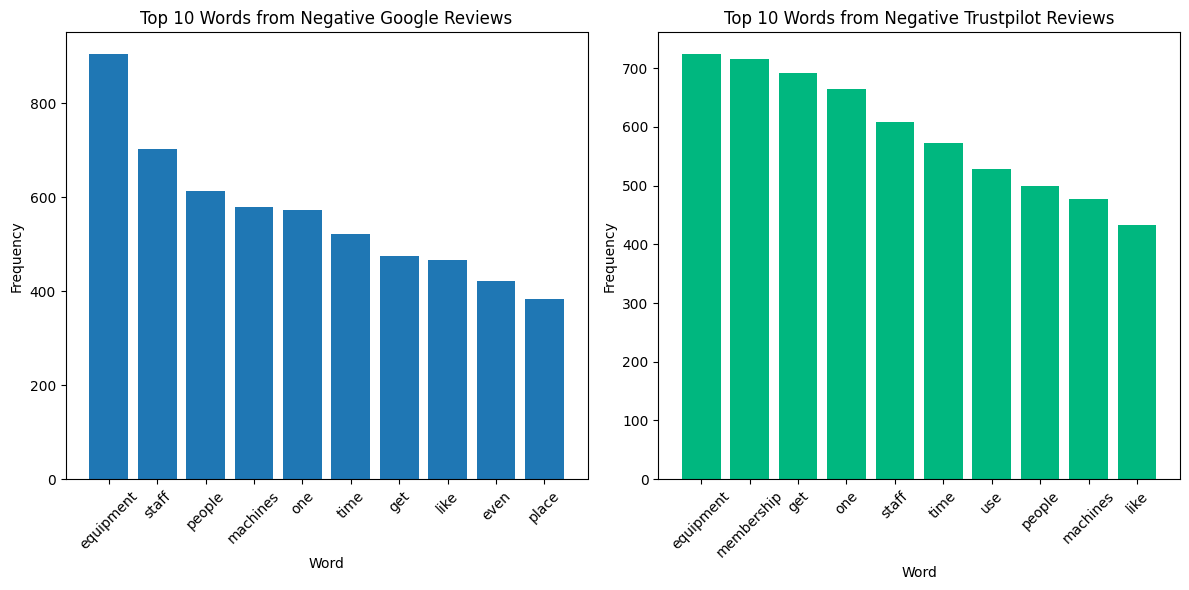

In [ ]:
# Plot a bar plot showing the top 10 words from each data set.

plt.figure(figsize=(12, 6))

# Get top 10 words and their frequencies for Google reviews
top_neg_words_google = fd_neg_google.most_common(11)[1:]
words_neg_google = [word for word, freq in top_neg_words_google]
freqs_neg_google = [freq for word, freq in top_neg_words_google]

# Plot the top 10 words from Google reviews in a bar plot
plt.subplot(1, 2, 1)
plt.bar(words_neg_google, freqs_neg_google)
plt.title('Top 10 Words from Negative Google Reviews')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)


# Get top 10 words and their frequencies for Trustpilot reviews
top_neg_words_trustpilot = fd_neg_trustpilot.most_common(11)[1:]
words_neg_trustpilot = [word for word, freq in top_neg_words_trustpilot]
freqs_neg_trustpilot = [freq for word, freq in top_neg_words_trustpilot]

# Plot the top 10 words from Trustpilot reviews in a bar plot
plt.subplot(1, 2, 2)
plt.bar(words_neg_trustpilot, freqs_neg_trustpilot, color='#00B77F') # Hex code for Trustpilot green
plt.title('Top 10 Words from Negative Trustpilot Reviews')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

Again we'll create a Word Cloud for each set of negative reviews to visualise the most common words. We'll use separate colourmaps from previously to easily tell them apart.

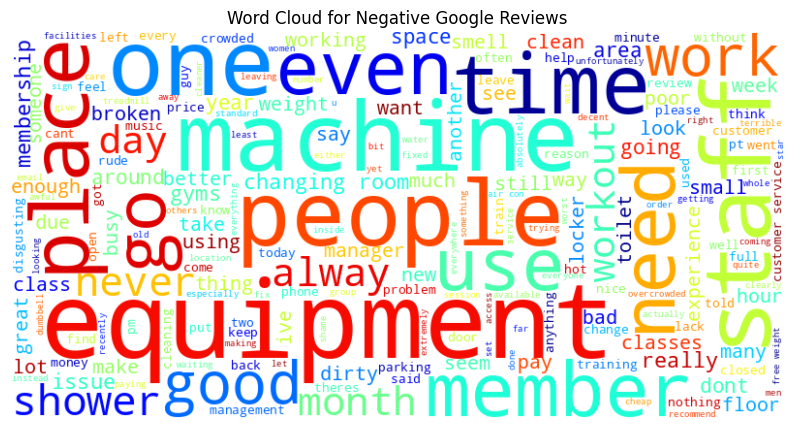

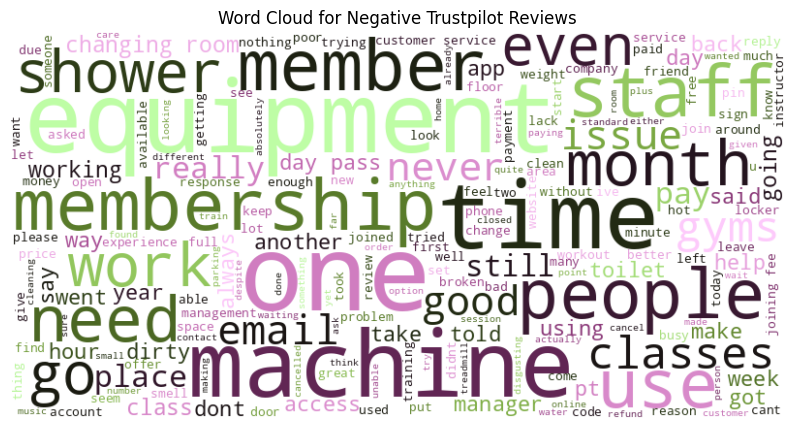

In [ ]:
# Generate word cloud for Google reviews
neg_words_google_text = " ".join(neg_words_google)
wordcloud_google_neg = WordCloud(width=800, height=400, random_state=19, max_font_size=110, background_color="white", colormap='jet').generate(neg_words_google_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_google_neg, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Negative Google Reviews')
plt.show()

# Generate word cloud for Trustpilot reviews
neg_words_trustpilot_text = " ".join(neg_words_trustpilot)
wordcloud_trustpilot_neg = WordCloud(width=800, height=400, random_state=19, max_font_size=110, background_color="white", colormap='vanimo').generate(neg_words_trustpilot_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_trustpilot_neg, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Negative Trustpilot Reviews')
plt.show()

# BERTopic

With the dataframes of the negative reviews, we will filter out the reviews that are from the locations common to both data sets and merge the reviews to form a new list. This allows us to have a single dataset which is looking at a consistent set of locations, with a sufficiently large sample size for proper analysis.

In [ ]:
# Recall we created a list of common locations earlier.
print("Common Locations:")
print(common_locs)

# Filter negative Google reviews for common locations
neg_google_common_locs = neg_google_reviews[neg_google_reviews['Club\'s Name'].isin(common_locs)].copy()

# Filter negative Trustpilot reviews for common locations
neg_trustpilot_common_locs = neg_trustpilot_reviews[neg_trustpilot_reviews['Location Name'].isin(common_locs)].copy()

# Merge the cleaned review content from both filtered dataframes into a single list
merged_neg_reviews = neg_google_common_locs['cleaned_comment'].tolist() + neg_trustpilot_common_locs['cleaned_review_content'].tolist()

print("\nFirst 5 cleaned and tokenized reviews from the merged list:")
print(merged_neg_reviews[:5])

Common Locations:
{'Nottingham Basford', 'Wolverhampton South', 'Cambridge Leisure Park', 'Southport', 'London Greenwich', 'London Hayes', 'Sutton Times Square', 'London Limehouse', 'London Putney', 'London Lambeth', 'Coventry Skydome', 'Newport Gwent', 'Bristol Brislington', 'Rochdale', 'Hereford', 'Burnham', 'Plymouth Marsh Mills', 'Motherwell', 'London Enfield', 'Falkirk', 'Bridgwater', 'London Finsbury Park', 'Consett', 'Manchester Debdale', 'Glasgow Milngavie', 'Hatfield', 'Derby Kingsway', 'Worcester', 'Nottingham Castle Marina', 'Linlithgow', 'Derby', 'Tunbridge Wells', 'Wolverhampton Bentley Bridge', 'Sheffield Millhouses', 'Ipswich Ravenswood', 'Cardiff Gate', 'London Lewisham', 'Leicester St Georges Way', 'London Greenwich Movement', 'Cardiff Western Avenue', 'Northallerton', 'Norwich Aylsham Road', 'Grimsby', 'Chatham', 'Peterborough Brotherhood Retail Park', 'Runcorn', 'Canterbury Sturry Road', 'South Ruislip', 'London Acton', 'Birmingham West', 'Gateshead', 'Dudley Tipton'

We will save the merged negative reviews dataset using pickle so that it can be used in the LDA notebook.

In [ ]:
# Save merged_neg_reviews using pickle

# save_path = "merged_neg_reviews.pkl"

# with open(save_path, 'wb') as f:
#   pickle.dump(merged_neg_reviews, f)


We'll run BERTopic on the dataset and list out the top topics along with their document frequencies.

In [ ]:
# Convert the list of tokenized reviews back to strings for BERTopic
merged_neg_reviews_text = [" ".join(tokens) for tokens in merged_neg_reviews]

# Initialise the BERTopic model
topic_model = BERTopic(verbose=False)

# Fit the model on the merged negative reviews
topics, probs = topic_model.fit_transform(merged_neg_reviews_text)

# Get the top topics and their document frequencies
top_topics = topic_model.get_document_info(merged_neg_reviews_text)

print("Top topics and their document frequencies:")
display(top_topics['Topic'].value_counts())

For the top 2 topics, we'll list out the top words to get an idea of what BERTopic's output looks like.

In [ ]:
# Get the top 2 topics (excluding topic -1, which represents outliers)
top_2_topics = topic_model.get_topic_info().head(3)[1:] # Get top 3 including -1, then slice

# List out the top words for the top 2 topics
print("Top words for the top 2 topics:")
for topic_id in top_2_topics['Topic']:
  print(f"\nTopic {topic_id}:")
  display(topic_model.get_topic(topic_id))

Top words for the top 2 topics:

Topic 0:


[('air', np.float64(0.05917516190247903)),
 ('conditioning', np.float64(0.03480910358687236)),
 ('hot', np.float64(0.029162393165723145)),
 ('ac', np.float64(0.02729212396074352)),
 ('con', np.float64(0.024610651612887138)),
 ('aircon', np.float64(0.02438105197979246)),
 ('heat', np.float64(0.019133627605478955)),
 ('summer', np.float64(0.018951893915877954)),
 ('temperature', np.float64(0.01694376597979386)),
 ('working', np.float64(0.016367849540863514))]


Topic 1:


[('toilets', np.float64(0.06278480358713656)),
 ('dirty', np.float64(0.04081587799333383)),
 ('changing', np.float64(0.0383247453596923)),
 ('rooms', np.float64(0.031122308816148664)),
 ('toilet', np.float64(0.027496222607399087)),
 ('disgusting', np.float64(0.024120652198719828)),
 ('cleaning', np.float64(0.02237135148995789)),
 ('clean', np.float64(0.021610670581128262)),
 ('smelly', np.float64(0.020464403819553254)),
 ('smell', np.float64(0.0199757472072052))]

Below we'll show some visualisations and compare them to see which gives the best view of the topics output by the model.

We'll show an intertopic distance map to identify clusters of topics:

In [ ]:
# Show an interactive visualisation of the topics
print("\nInteractive topic map visualization:")
topic_model.visualize_topics()


Interactive topic map visualization:


We'll also show a barchart of the topics displaying the top 5 words in each topic:

In [ ]:
# Show a barchart of the topics displaying the top 5 words in each topic
print("Bar chart of topics with top 5 words:")
topic_model.visualize_barchart()

Bar chart of topics with top 5 words:


And a heatmap showcasing the similarity matrix:

In [ ]:
# Plot a heatmap, showcasing the similarity matrix
print("\nHeatmap of topic similarity matrix:")
topic_model.visualize_heatmap()


Heatmap of topic similarity matrix:


The intertopic distance map is clearly the superior visualisation, combining the ability to see the top 5 words for each individual topic from the bar chart and the ability to see the similarity between topics from the heatmap.

There are 11 distinct clusters on the Intertopic Distance Map above. Below is some commentary on each cluster - they will be labelled by the lowest topic in the cluster for simplicity's sake.

- **Topic 0 Cluster:** This is a large cluster, with topics on issues surrounding air conditioning, parking, WiFi, and loud music.

- **Topic 1 Cluster:** This is a large but tight cluster, with topics mainly discussing lack of cleanliness in the toilets.

- **Topic 3 Cluster:** This is a small cluster, with topics focusing on issues with weights - there are some topics surrounding equipment in the topic 0 cluster so it is odd that these are separate.

- **Topic 6 Cluster:** This cluster is also small, with topics focuisng on issues customers have had with classes.

- **Topic 7 Cluster:** This is another small cluster surrounding membership issues. There's also a topic in there about the CEO which is an odd fit.

- **Topic 8 Cluster:** This is a small cluster around two separate themes, one of them lockers and the other around cleanliness - this is close to the topic 1 cluster, which makes sense.

- **Topic 10 Cluster:** This cluster focuses on staff attitude, with one of the topics being about teenagers (presumably the model has been trained on text which characterises teenagers by their attitude).

- **Topic 12 Cluster:** This cluster is about the pin access code you use to get into PureGym locations - this is far away from other clusters in the top right corner as it isn't closely related to any other topics.

- **Topic 15 Cluster:** This is a small cluster about showers. This is close to the topic 1 cluster about toilets which follows a theme but a similar distance from the Topic 0 'general facilities' cluster.

- **Topic 21 Cluster:** This is a small cluster with topics about how busy the gym is, people on their phones - overall the theme is to do with wait times.

- **Topic 32 Cluster:** This cluster contains two topics, both about machines being broken. This seems like it could fit with a couple of the topics in the Topic 0 cluster so the distance is odd.


# Location Analysis

Ideally we want to look at the locations with the most negative reviews, as those are priority areas for PureGym to address. As such, we'll list out the top 20 locations with the highest number of negative reviews separately for Google and Trustpilot's reviews.


In [ ]:
# List out the top 20 locations with the highest number of negative reviews for Google
top_20_neg_locations_google = neg_google_reviews['Club\'s Name'].value_counts().head(20)
print("Top 20 locations with the highest number of negative Google reviews:")
display(top_20_neg_locations_google)

# List out the top 20 locations with the highest number of negative reviews for Trustpilot
top_20_neg_locations_trustpilot = neg_trustpilot_reviews['Location Name'].value_counts().head(20)
print("\nTop 20 locations with the highest number of negative Trustpilot reviews:")
display(top_20_neg_locations_trustpilot)


In [ ]:
# Show which locations appear in both lists

print("Locations that appear in both lists:")
common_neg_locs = set(top_20_neg_locations_google.index).intersection(set(top_20_neg_locations_trustpilot.index))
print(common_neg_locs)

This is an overlap of 40%, which is notable. However, there are likely more gyms with 16 negative Google reviews and 14 negative Trustpilot reviews so this could be higher or lower - the small similar numbers of negative reviews at a lot of gyms makes this overlap rate somewhat arbitrary.

Obviously '345' is not a location. Based on the fact that Woolwich has 0 negative Trustpilot reviews, we can assume that '345' in the Trustpilot dataset corresponds to the London Woolwich location. This is supported by a cursory look at the raw data.

As such, we will rename '345' in the Trustpilot dataset to 'London Woolwich' to correspond with the Google dataset.

In [ ]:
# Rename '345' to 'London Woolwich' in the Trustpilot dataset and rerun

neg_trustpilot_reviews['Location Name'] = neg_trustpilot_reviews['Location Name'].replace(345, 'London Woolwich')


Now we'll merge the 2 datasets with locations, number of reviews from each dataset, total number of reviews and sort based on the total number of reviews.

In [ ]:
# Count the number of Google reviews per location
google_neg_review_counts = neg_google_reviews['Club\'s Name'].value_counts().reset_index()
google_neg_review_counts.columns = ['Location', 'Google Review Count']

# Count the number of Trustpilot reviews per location
trustpilot_neg_review_counts = neg_trustpilot_reviews['Location Name'].value_counts().reset_index()
trustpilot_neg_review_counts.columns = ['Location', 'Trustpilot Review Count']

# Merge the review counts based on location name
merged_neg_review_counts = pd.merge(google_neg_review_counts, trustpilot_neg_review_counts, on='Location', how='outer').fillna(0)

# Calculate the total number of reviews
merged_neg_review_counts['Total Review Count'] = merged_neg_review_counts['Google Review Count'] + merged_neg_review_counts['Trustpilot Review Count']

# Sort based on the total number of reviews
merged_neg_review_counts_sorted = merged_neg_review_counts.sort_values(by='Total Review Count', ascending=False)

print("Location review counts from Google and Trustpilot (sorted by total review count):")
display(merged_neg_review_counts_sorted.head(30))

Location review counts from Google and Trustpilot (sorted by total review count):


,Location,Google Review Count,Trustpilot Review Count,Total Review Count
293,London Stratford,59.0,22.0,81.0
305,London Woolwich,26.0,45.0,71.0
221,Leicester Walnut Street,11.0,48.0,59.0
257,London Enfield,25.0,23.0,48.0
295,London Swiss Cottage,23.0,15.0,38.0
70,Birmingham City Centre,21.0,14.0,35.0
239,London Bermondsey,16.0,18.0,34.0
331,New Barnet,20.0,14.0,34.0
288,London Seven Sisters,17.0,16.0,33.0
266,London Hayes,17.0,16.0,33.0


Now we have the top 30 locations with the most negative reviews, we can redo the word frequency and word cloud to get an idea of the issues at these 30 'worst' locations.

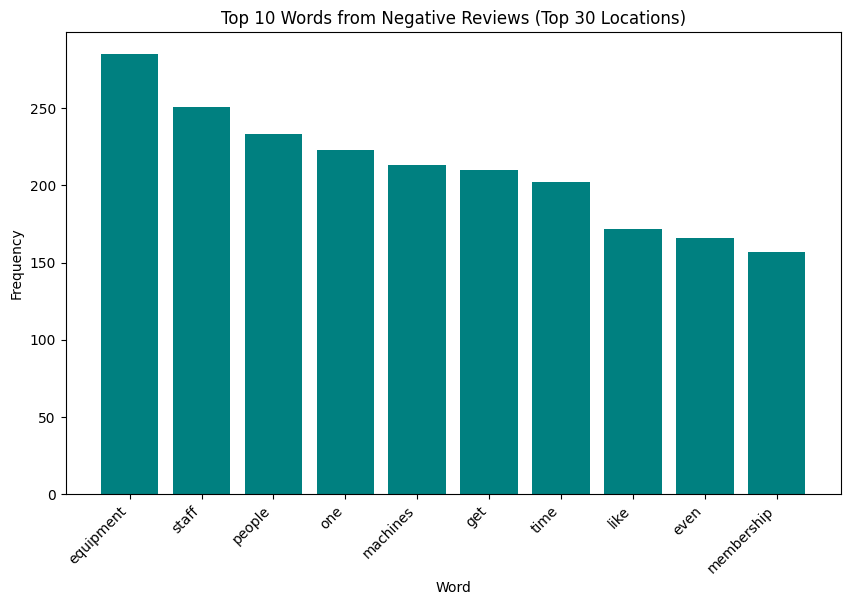

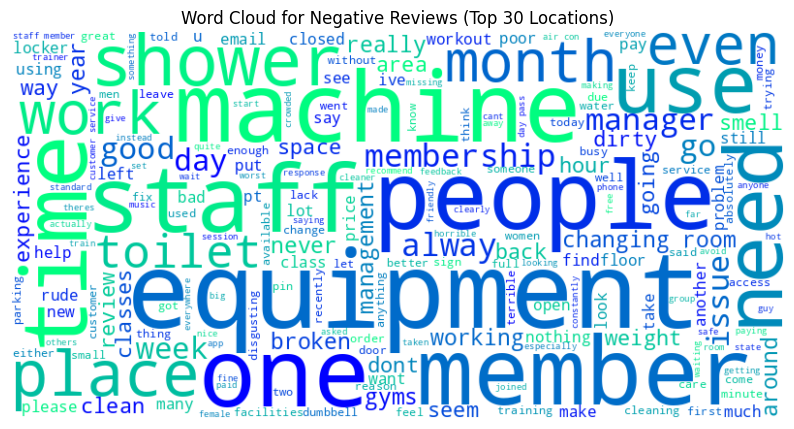

In [ ]:
# Get the list of top 30 locations with the most negative reviews
top_30_locations = merged_neg_review_counts_sorted['Location'].head(30).tolist()

# Filter negative Google reviews for the top 30 locations
neg_google_top_30 = neg_google_reviews[neg_google_reviews['Club\'s Name'].isin(top_30_locations)]

# Filter negative Trustpilot reviews for the top 30 locations
neg_trustpilot_top_30 = neg_trustpilot_reviews[neg_trustpilot_reviews['Location Name'].isin(top_30_locations)]

# Combine the cleaned review content from the filtered dataframes
all_neg_words_top_30 = neg_google_top_30['cleaned_comment'].tolist() + neg_trustpilot_top_30['cleaned_review_content'].tolist()

# Flatten the list of lists into a single list of words
all_neg_words_top_30_flat = [word for tokens in all_neg_words_top_30 for word in tokens]

# Find the frequency distribution of words for the top 30 locations
fd_neg_top_30 = FreqDist(all_neg_words_top_30_flat)

# Plot a bar plot showing the top 10 words from the negative reviews of top 30 locations
plt.figure(figsize=(10, 6))
top_neg_words_top_30 = fd_neg_top_30.most_common(11)[1:]
words_neg_top_30 = [word for word, freq in top_neg_words_top_30]
freqs_neg_top_30 = [freq for word, freq in top_neg_words_top_30]

plt.bar(words_neg_top_30, freqs_neg_top_30, color='teal')
plt.title('Top 10 Words from Negative Reviews (Top 30 Locations)')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

# Generate word cloud for the negative reviews from top 30 locations
all_neg_words_top_30_text = " ".join(all_neg_words_top_30_flat)
wordcloud_neg_top_30 = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color="white", colormap='winter').generate(all_neg_words_top_30_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_neg_top_30, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Negative Reviews (Top 30 Locations)')
plt.show()

The word frequency bar chart showing the 10 most used words at those 30 locations is almost identical (same words, slightly different order) to the chart showing the top 10 words used in negative Google reviews and very similar to the chart showing the top 10 words used in negative Trustpilot reviews (9/10 same words).  

The word cloud also shows a lot of similarity to the individual ones for negative Google and Trustpilot reviews. This would suggest that this Top 30 is a representative sample of common complaints people have with PureGyms.

The next step is to merge the reviews from the Google and Trustpilot datasets for the top 30 'worst' locations and run them through BERTopic.

In [ ]:
# Convert the list of tokenized reviews back to strings for BERTopic
merged_neg_reviews_top_30_text = [" ".join(tokens) for tokens in all_neg_words_top_30]

# Create a new BERTopic model to use for visualisations

topic_model_30 = BERTopic()

# Fit the model on the merged negative reviews from the top 30 locations
topics_top_30, probs_top_30 = topic_model_30.fit_transform(merged_neg_reviews_top_30_text)

# Get the top topics and their document frequencies for the top 30 locations
top_topics_top_30 = topic_model_30.get_document_info(merged_neg_reviews_top_30_text)

print("Top topics and their document frequencies for negative reviews from Top 30 locations:")
display(top_topics_top_30['Topic'].value_counts())

Top topics and their document frequencies for negative reviews from Top 30 locations:


,count
Topic,
0,185
-1,181
1,98
2,92
3,61
4,59
5,54
6,47
7,45


In [ ]:
# Get the top 10 topics
top_3_topics = topic_model_30.get_topic_info().head(4)[1:]

# List out the top words for the top 10 topics

print("Top words for the 3 topics:")
for topic_id in top_3_topics['Topic']:
  print(f"\nTopic {topic_id}:")
  display(topic_model_30.get_topic(topic_id))

Top words for the 3 topics:

Topic 0:


[('toilets', np.float64(0.027000956588278256)),
 ('no', np.float64(0.026495266803262325)),
 ('cleaning', np.float64(0.025338716452580748)),
 ('dirty', np.float64(0.022157812756683142)),
 ('equipment', np.float64(0.021201884675750172)),
 ('toilet', np.float64(0.018651435257526564)),
 ('changing', np.float64(0.018493669354232998)),
 ('machines', np.float64(0.018180270094009153)),
 ('like', np.float64(0.018008000414011942)),
 ('smell', np.float64(0.0178751394334195))]


Topic 1:


[('manager', np.float64(0.03054925577039403)),
 ('rude', np.float64(0.030066852942304535)),
 ('staff', np.float64(0.029925551766437467)),
 ('member', np.float64(0.025446728586408944)),
 ('people', np.float64(0.01780229059708996)),
 ('management', np.float64(0.01655003607125301)),
 ('reviews', np.float64(0.016289787155634797)),
 ('pt', np.float64(0.015381311162831458)),
 ('one', np.float64(0.01489975727172424)),
 ('like', np.float64(0.014695716542355002))]


Topic 2:


[('pin', np.float64(0.06672430993895505)),
 ('membership', np.float64(0.04216114439559562)),
 ('email', np.float64(0.042010954650640794)),
 ('day', np.float64(0.041151330052440316)),
 ('pass', np.float64(0.04043264992145923)),
 ('code', np.float64(0.0396049051565732)),
 ('get', np.float64(0.03560134563358181)),
 ('app', np.float64(0.035149030598846547)),
 ('paid', np.float64(0.03332599990445817)),
 ('work', np.float64(0.031942771317808726))]

In [ ]:
# Show an interactive visualisation of the topics
print("\nInteractive topic map visualization:")
topic_model_30.visualize_topics()


Interactive topic map visualization:


The first thing to note is that there are fewer individual topics; this is to be expected with a smaller list. This leads to a lack of clustering, as the smaller list of reviews results in similar reviews being grouped into one topic rather than multiple.

As such, this allows us to use the size of the topics to more accurately ascertain customers' biggest concerns.

# Emotion Analysis

To ascertain customers' biggest concerns, we need to see which flaws cause the strongest emotional response in customers, as that is a key driver of customer behaviour. The next stage is to perform emotion analysis to find what the main causes of angry reviews are.

For this, we'll be using HuggingFace Transformers. We need to import the bhadresh-savani/bert-base-uncased-emotion model from Hugging Face, and set up a pipeline for text classification.



In [ ]:
classifier = pipeline("text-classification",
                      model='bhadresh-savani/bert-base-uncased-emotion',
                      return_all_scores=True)

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


With the help of an example sentence, we'll run the model and display the different emotion classifications that the model outputs.

In [ ]:
prediction = classifier("Oh great, another meeting that could’ve been an email — my day is now complete.", )
print(prediction)

[[{'label': 'sadness', 'score': 0.0029876898042857647}, {'label': 'joy', 'score': 0.9937483072280884}, {'label': 'love', 'score': 0.0005844560801051557}, {'label': 'anger', 'score': 0.0014050748432055116}, {'label': 'fear', 'score': 0.0006013177917338908}, {'label': 'surprise', 'score': 0.0006730565219186246}]]


That sentence was used to assess the model's ability to understand sarcasm - it exceeded expectations! This is worth noting for reviews written with a level of cynicism - perhaps a specific model to filter out sarcastic reviews before this model attempts emotion analysis could be a solution.

The model can output the following emotions: Sadness, Fear, Joy, Anger, Love, Surprise. Given we only want to output the top emotion for each review, we need to modify the pipeline. I am also adding truncation and padding parameters so that reviews are equal length - I have chosen truncation over using the cleaned comments as removing stopwords can remove important meaning and it is unnecessary for LLMs such as this.

In [ ]:
classifier = pipeline("text-classification",
                      model='bhadresh-savani/bert-base-uncased-emotion',
                      top_k=1,
                      truncation=True,
                      padding=True)

Device set to use cuda:0


I'll quickly test a sentence with an angry theme to assess the model's ability to do the task in mind.

In [ ]:
prediction = classifier("I’ve asked three times, and it’s still not done.", )
print(prediction)

[[{'label': 'anger', 'score': 0.9747284054756165}]]


Having made the classifier model, it now needs to be run on both datasets to capture the top emotion for each review. This takes a while to run so I will be doing it exclusively on the negative reviews from the top 30 locations from each dataset.

In [ ]:
# Function to get the top emotion from the classifier output
def get_top_emotion(prediction_output):
    # The output is a list containing a list of dictionaries, like [[{'label': 'sadness', 'score': 0.99}, ...]] - we only want the emotion
    if prediction_output and isinstance(prediction_output[0], list) and prediction_output[0]:
        return prediction_output[0][0]['label']
    return None # Return None if the output is not in the expected format

# Apply the classifier to the 'Comment' column in the Google dataset
neg_google_top_30['top_emotion'] = neg_google_top_30['Comment'].apply(lambda x: get_top_emotion(classifier(x)) if pd.notna(x) else None)

# Apply the classifier to the 'Review Content' column in the Trustpilot dataset
neg_trustpilot_top_30['top_emotion'] = neg_trustpilot_top_30['Review Content'].apply(lambda x: get_top_emotion(classifier(x)) if pd.notna(x) else None)

print("Google Reviews DataFrame with top emotion:")
display(neg_google_top_30.head())

print("\nTrustpilot Reviews DataFrame with top emotion:")
display(neg_trustpilot_top_30.head())

Next step is to visualise the top emotion distribution for all negative reviews:

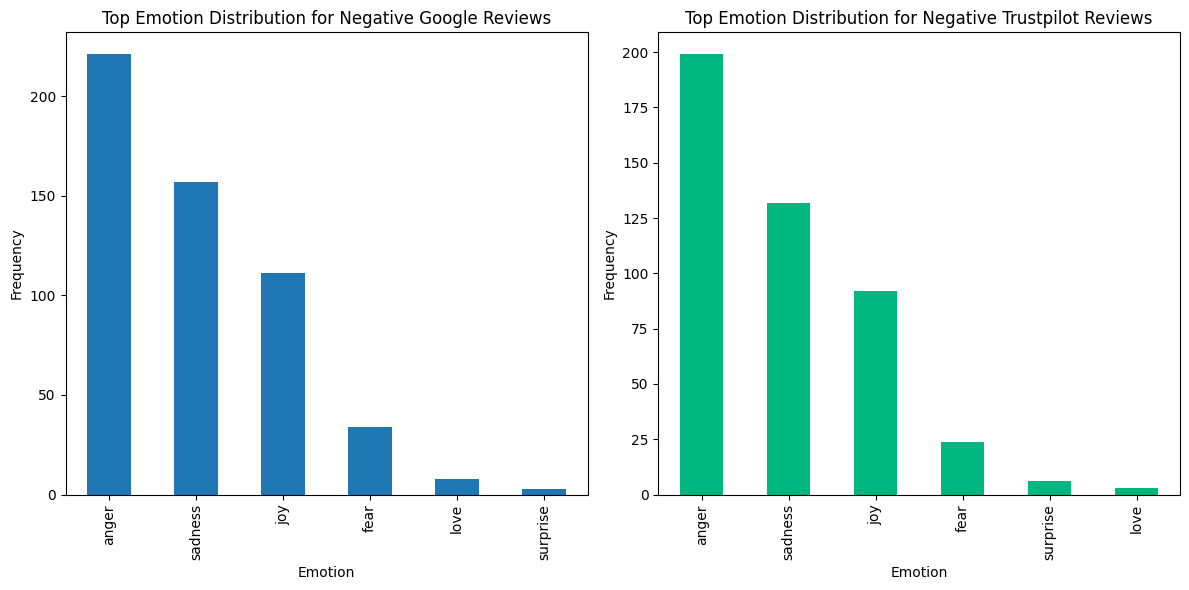

In [ ]:
# Plot a bar plot to show the top emotion distribution for all negative reviews in both datasets

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
neg_google_top_30['top_emotion'].value_counts().plot(kind='bar')
plt.title('Top Emotion Distribution for Negative Google Reviews')
plt.xlabel('Emotion')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
neg_trustpilot_top_30['top_emotion'].value_counts().plot(kind='bar', color='#00B77F') # Hex code for Trustpilot green
plt.title('Top Emotion Distribution for Negative Trustpilot Reviews')
plt.xlabel('Emotion')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Anger is the top emotion for negative reviews at the top 30 locations. To find out why, we will run BERTopic on these reviews, and compare the output to previously.

We will start by extracting the reviews where anger is the top emotion and merging the two datasets into a single list.

In [ ]:
# Extract the reviews where anger is the top emotion

anger_reviews_google = neg_google_top_30[neg_google_top_30['top_emotion'] == 'anger']
anger_reviews_trustpilot = neg_trustpilot_top_30[neg_trustpilot_top_30['top_emotion'] == 'anger']

# Combine the cleaned review content from the filtered dataframes
merged_angry_reviews = anger_reviews_google['cleaned_comment'].tolist() + anger_reviews_trustpilot['cleaned_review_content'].tolist()

print("\nFirst 5 angry reviews from the merged list (cleaned & tokenized)")
print(merged_angry_reviews[:5])


First 5 angry reviews from the merged list (cleaned & tokenized)
[['way', 'hot', 'even', 'workout', 'no', 'windows', 'open', 'ac', 'barely', 'works', 'staff', 'no', 'near', 'friendly', 'always', 'rude', 'especially', 'men', 'clients', 'mean', 'work'], ['airconditioning', 'doesnt', 'work'], ['staff', 'allowed', 'blame', 'annoying', 'people', 'hoxton', 'get', 'second', 'time', 'working', 'guy', 'clear', 'brown', 'hair', 'work', 'start', 'blame', 'dressing', 'heavy', 'metal', 'shirt', 'singer', 'band', 'criminal', 'past', 'thats', 'employee', 'blaming', 'wonder', 'guy', 'make', 'circus', 'hip', 'hop', 'rock', 'shirt', 'go', 'amy', 'winehouse', 'shirt', 'would', 'like', 'staff', 'bother', 'telling', 'drug', 'addicted', 'whats', 'point', 'suggest', 'better', 'choose', 'page', 'wages', 'guy', 'ruined', 'mood', 'work', 'today'], ['absolute', 'filthy', 'toilet', 'machines', 'machines', 'usually', 'broken', 'no', 'timeline', 'fix', 'cleaners', 'seem', 'clean', 'machine', 'covid', 'sanitisation

We will run BERTopic on the merged list.

In [ ]:
# Convert the list of tokenized reviews back to strings for BERTopic
merged_angry_reviews_text = [" ".join(tokens) for tokens in merged_angry_reviews]

# Create a new BERTopic model for visualisations
topic_model_anger = BERTopic()

# Fit the model on the merged angry reviews
topics_anger, probs_anger = topic_model_anger.fit_transform(merged_angry_reviews_text)

# Get the top topics and their document frequencies for the angry reviews
top_topics_anger = topic_model_anger.get_document_info(merged_angry_reviews_text)

print("Top topics and their document frequencies for angry reviews:")
display(top_topics_anger['Topic'].value_counts())

Top topics and their document frequencies for angry reviews:


,count
Topic,
0,398
1,22


In [ ]:
# Show a barchart of the topics displaying the top 5 words in each topic
print("\nBar chart of topics with top 5 words for angry reviews:")
topic_model_anger.visualize_barchart()


Bar chart of topics with top 5 words for angry reviews:


As there are only two topics, we cannot visualise the clusters on an intertopic distance map. This is despite attempts to fine tune BERTopic to maximise topic diversity. The lack of topic diversity would suggest that the majority of the angry reviews follow a similar theme, or that not enough of them have distinct topics that can be picked up by BERTopic.

This would not be too surprising if the reviews are more angry than coherent, or if the angry complaints are just generic, but looking at the reviews directly will confirm. Further attempts to tune the model to generate a visualisation could also be made.

# Using LLMs for Further Analysis

To get a better idea of the reasons behind angry reviews, we will use the Falcon-7b-instruct model to find the top 3 topics in each angry review.

In [ ]:
# Instantiate the model

model_n = "tiiuae/falcon-7b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_n)

gen_pipeline = pipeline(
    "text-generation",
    model=model_n,
    tokenizer=tokenizer,
    torch_dtype="auto",
    device_map="auto"
    )

We'll the model on the angry reviews at the top 30 locations.

In [ ]:
# Define the prompt
prompt_template = ("In the following customer review, pick out the main 3 topics. Return them in a numbered list format, with each one on a new line. Stop after three")

# List to store the generated topics
generated_topics_list = []

# Iterate through each angry review and apply the model
for review_tokens in merged_angry_reviews:
    review_text = " ".join(review_tokens) # Join tokens back into string like for BERTopic
    prompt = prompt_template.format(review=review_text)

    try:
        sequences = gen_pipeline(
            prompt,
            max_new_tokens=128,
            do_sample=True, # I have made the model probabilistic because I have a preference for randomness
            temperature=0.5, # However too much randomness isn't ideal which is why I have chosen a low temperature
            num_return_sequences=1,
            eos_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id else None,
        )
        # Extract the generated topics
        generated_text = sequences[0]['generated_text']
        # The generated text will include the prompt, so we need to extract the part after "Topics:"
        topics_part = generated_text.split("Topics:")[-1].strip()
        generated_topics_list.append(topics_part)

    except Exception as e:
        print(f"Error processing review: {review_text[:100]}...") # Print first 100 chars of problematic review
        print(f"Error: {e}")
        generated_topics_list.append("") # Append empty string or handle error as needed


print("Generated topics for the first 5 angry reviews:")
for i, topics in enumerate(generated_topics_list[:5]):
    print(f"Review {i+1}:\n{topics}\n---")

Some of the outputs are not in the correct format (more than 3 topics) - as such we need to see how many of them there are as a high proportion of bad outputs could corrupt the results.

# Continuation of LLM Analysis

In [ ]:
# Set up a function to identify outputs in the incorrect format

def is_valid_topic_format(text):
    topic_lines = re.findall(r'^\s*\d\.\s+.+', text, flags=re.MULTILINE)
    return len(topic_lines) == 3

bad_indices = [i for i, output in enumerate(generated_topics_falcon_list) if not is_valid_topic_format(output)]
print(f"{len(bad_indices)} bad outputs found.")

60 bad outputs found.


There are 420 outputs overall, meaning a bad output rate of 14.3%. That is too much, so I will rerun the model exclusively on the bad outputs. Due to a level of randomness in the emotion analysis model, the saved list of generated topics and the list of merged angry reviews may be different lengths. To prevent this causing errors when running the model, we will filter bad_indices.

In [ ]:
# To prevent errors if generated_topics_falcon_list and merged_angry_reviews are not the same length
bad_indices = [
    i for i in bad_indices
    if i < len(merged_angry_reviews)
]

The previous prompt was insufficiently clear/specific, therefore a more direct prompt will be given here.

In [ ]:
# Define the prompt
prompt_template2 = (
    "Extract the **3 main topics** from the following customer review. "
    "Return them as a numbered list (1 to 3), with each topic on its own line. "
    "Do not return more than 3 topics.\n\n"
    "Review: {review}\n\nTopics:"
)


We will run falcon-7b-instruct again below - the model will leave any good outputs from the original output and regenerate any bad ones, overwriting them.

In [ ]:
for i in bad_indices:
    review_text = " ".join(merged_angry_reviews[i])
    prompt = prompt_template2.format(review=review_text)

    try:
        sequence = gen_pipeline(
            prompt,
            max_length=200,
            do_sample=False,  # Trying deterministic here hoping it helps the model follow the prompt
            num_return_sequences=1,
            eos_token_id=tokenizer.eos_token_id,
        )[0]['generated_text']

        # Clean out the prompt part
        topics_part = sequence.split("Topics:")[-1].strip()
        generated_topics_falcon_list[i] = topics_part  # Overwrite the bad ones

    except Exception as e:
        print(f"Error reprocessing index {i}: {e}")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFO

We'll check the error rate again using the same code as above.

In [ ]:
# Repeat the same code as above to  check the error rate

bad_indices = [i for i, output in enumerate(generated_topics_falcon_list) if not is_valid_topic_format(output)]
print(f"{len(bad_indices)} bad outputs found.")

14 bad outputs found.


That's a much more acceptable error rate, we can proceed to running BERTopic to generate some visualisations of clusters.

# Running BERTopic on the LLM Output

In [ ]:
# Reload the improved output

with open("/content/drive/My Drive/generated_topics_falcon_7b_final.pkl", "rb") as f:
    generated_topics_falcon_list = pickle.load(f)

print(len(generated_topics_falcon_list))

420


Before running BERTopic, we need to flatten the list of topics into a single list rather than 420 lists of 3.

In [ ]:
# Generate a list which has extracted the actual topic text after the numbering

flat_topic_list = []

for entry in generated_topics_falcon_list:
    lines = entry.splitlines()
    for line in lines:
        topic = line.split(".", 1)[-1].strip()
        if topic:  # Check if the topic is not empty
            flat_topic_list.append(topic)

print(f"{len(flat_topic_list)} topics collected for BERTopic.")

1320 topics collected for BERTopic.


Obviously 1320 is more than would be expected for 3 topics from each of the 420 reviews, clearly some of the remaining bad outputs have significantly more than 3 topics.

To counteract issues with getting a number of topics that would visualise well, I have tuned BERTopic to maximise topic diversity.

In [ ]:
# Set up the parameters to maximise topic diversity

umap_model = UMAP(
    n_neighbors=5,       # Emphasize local structure
    n_components=15,     # More dimensions = more spread
    min_dist=0.1,        # Tight clusters
    metric='cosine',
    random_state=19
)

hdbscan_model = HDBSCAN(
    min_cluster_size=10,   # Allow small topic clusters
    min_samples=1,        # More sensitive to density
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

Now we'll run BERTopic with the fine-tuning for the visualisation in place.

In [ ]:
# Run BERTopic on the generated topics list

topic_model_topics = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

topics_topics, probs_topics = topic_model_topics.fit_transform(flat_topic_list)

top_topics_topics = topic_model_topics.get_document_info(flat_topic_list)

print("Top topics and their document frequencies for the generated topics:")
display(top_topics_topics['Topic'].value_counts())

2025-07-02 15:29:18,228 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/42 [00:00<?, ?it/s]

2025-07-02 15:29:28,064 - BERTopic - Embedding - Completed ✓
2025-07-02 15:29:28,065 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-02 15:29:32,457 - BERTopic - Dimensionality - Completed ✓
2025-07-02 15:29:32,458 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-02 15:29:32,847 - BERTopic - Cluster - Completed ✓
2025-07-02 15:29:32,852 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-02 15:29:32,913 - BERTopic - Representation - Completed ✓


Top topics and their document frequencies for the generated topics:


,count
Topic,
-1,88
0,40
1,39
2,37
3,37
...,...
56,11
57,11
58,10


In [ ]:
# Visualise the topics

# Show an interactive visualisation of the topics
print("\nInteractive topic map visualization:")
topic_model_topics.visualize_topics()


Interactive topic map visualization:


This is a significantly better Intertopic Distance Map - clearly the combination of an LLM to extract topics and BERTopic with the visualisation tuned on those topics is an effective method for identifying customer issues and grouping them.

However, it still generates some generic clusters, as well as some separate clusters that look like they ought to be together. The visualisation could likely be improved with further fine-tuning.

# Generating Insights

Data has little use for companies without actionable insights. As such, we are going to use an LLM to generate these insights based on the issues that customers have highlighted in their reviews. We will do this by running the phi-4-mini-instruct model.

In [ ]:
# Check the GPU is available

print("GPU available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

GPU available: True
Device: Tesla T4


In [ ]:
# Model name
model_n = "microsoft/phi-4-mini-instruct"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_n)

# Load model directly onto GPU
model = AutoModelForCausalLM.from_pretrained(
    model_n,
    torch_dtype=torch.float16,
).to("cuda")

# Build generation pipeline
gen_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0,
    torch_dtype=torch.float16
)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Device set to use cuda:0


I am attempting to gain actionable insights based on the list of topics as a whole, rather than as each individual topic in the list. However, our list is 1320 topics long, which may or may not exceed phi-4-mini-instruct's token limit, therefore we will split this into eight batches of 165 topics and process it like that, combining results at the end.

In [ ]:
# Define a function to split the topic list into batches
def batch_topics(topic_list, batch_size=165):
    """Split topic list into batches of specified size."""
    for i in range(0, len(topic_list), batch_size):
        yield topic_list[i:i + batch_size]

topic_batches = list(batch_topics(flat_topic_list, batch_size=165))
print(f"Number of batches: {len(topic_batches)}")

Number of batches: 8


As the given prompt had issues in the previous step, I am sharpening up the prompt to attempt to get a good output on the first attempt.

In [ ]:
# Create the prompt
prompt_template_phi = """You are an expert business consultant.

The following are text topics extracted from negative gym reviews. Based on these, generate 3 distinct, actionable business insights grouped by common themes across the topics.
These should be actionable insights that the gym group could implement to improve their service and address customer concerns.

Each insight should:
1. Begin with a short descriptive theme (in bold).
2. Be followed by 1-2 sentences describing what the gym should do.

Only output the 3 insights in this format.
"""

We will now run the model. As runtime issues persist, we will save after each batch and load back in so that we can ensure progress.

In [ ]:
# Define where to save after each batch
save_path = "/content/drive/MyDrive/phi4_batch_insights.pkl"

# Try loading existing file if resuming
if os.path.exists(save_path):
    with open(save_path, "rb") as f:
        batch_insights = pickle.load(f)
    print(f"Resuming from previous progress: {len(batch_insights)} batches completed.")
else:
    batch_insights = []

# Start from where we left off
start_batch = len(batch_insights)

# Join the topics into a single string so they can be processed together
for i, batch in enumerate(topic_batches):
    topics_str = "\n".join(batch)
    prompt = prompt_template_phi.format(topics=topics_str)

    # Apply the model
    try:
        response = gen_pipeline(
            prompt,
            max_new_tokens=256,
            do_sample=True,
            top_k=50,
            temperature=0.7,
            num_return_sequences=1,
            eos_token_id=tokenizer.eos_token_id
            )

        # Extract the generated insights and list them
        output = response[0]['generated_text']
        insights = output.split("Insights:")[-1].strip()
        batch_insights.append(insights)
        print(f"Batch {i + 1} processed.")

    except Exception as e:
        print(f"Error in batch {i + 1}: {e}")
        batch_insights.append("ERROR")

    # Overwrite after every batch
    with open(save_path, "wb") as f:
        pickle.dump(batch_insights, f)

Batch 1 processed.
Batch 2 processed.
Batch 3 processed.
Batch 4 processed.
Batch 5 processed.
Batch 6 processed.
Batch 7 processed.
Batch 8 processed.


We'll now combine the insights generated by each batch of topics. From there, we will be able to see if there is any overlap and identify key areas for improvement

In [ ]:
# Combine the outputs and print
print("\nFull Combined Insights:\n")
for i, insight in enumerate(batch_insights):
    print(f"--- Batch {i + 1} Insights ---\n{insight}\n")


Full Combined Insights:

--- Batch 1 Insights ---
You are an expert business consultant.

The following are text topics extracted from negative gym reviews. Based on these, generate 3 distinct, actionable business insights grouped by common themes across the topics.
These should be actionable insights that the gym group could implement to improve their service and address customer concerns.

Each insight should:
1. Begin with a short descriptive theme (in bold).
2. Be followed by 1-2 sentences describing what the gym should do.

Only output the 3 insights in this format.
Insight 1: **[Theme] - [What to do]**
Insight 2: **[Theme] - [What to do]**
Insight 3: **[Theme] - [What to do]**

Topics:
1. Lack of variety in classes
2. Poor customer service
3. Unfriendly staff
4. Inadequate space
5. Lack of cleanliness
6. Poor quality of equipment
7. Inaccessible location
8. Unreliable opening hours
9. Limited parking facilities
10. Absence of professional trainers
11. Weak Wi-Fi connection
12. U

Obviously the format of these reviews is inconsistent due to the separate batches, and some include topics and individual reviews which was not requestsed. However, the output for batches 3, 4, 7 and 8 are all good.

I will condense the overall output into three actionable insights that the gym can use to improve its service, using the insights that come up most across the 8 batches.

1. **Facility Cleanliness:** Establish a strict cleaning schedule and assign specific staff members to responsibility, ensuring that the gym remains clean and hygienic at all times.

2. **Staff Training:** The gym should invest in ongoing staff training programs focused on customer service to ensure all employees are equipped to provide a positive experience and are knowledgeable about equipment usage.

3. **Equipment Maintenance:** Implement a regular maintenance schedule and routine checks for all equipment, reducing the risk of malfunctions and ensuring a safe workout environment for members.

